# Create timetable and footpaths data structures

In [1]:
import pandas as pd
stop_trip_combinations = pd.read_csv('data/stop_times_df.csv', index_col=0)
stop_trip_combinations['dep_time'] = pd.to_timedelta(stop_trip_combinations['arrival_time_dt']).dt.total_seconds()
stop_trip_combinations['arr_time'] = pd.to_timedelta(stop_trip_combinations['departure_time_dt']).dt.total_seconds()
stop_trip_combinations = stop_trip_combinations[['trip_id', 'stop_id', 'dep_time', 'arr_time']]
stop_trip_combinations.sort_values(by=['trip_id', 'arr_time'])
stop_trip_combinations.head()

,trip_id,stop_id,dep_time,arr_time
0,143.TA.91-15-B-j24-1.1161.H,8501120:0:1,71040.0,70860.0
1,143.TA.91-1-M-j24-1.50.R,8501117:0:3,82500.0,82440.0
2,143.TA.91-1-M-j24-1.50.R,8501118:0:4,82680.0,82620.0
3,143.TA.91-1-M-j24-1.50.R,8518452:0:2,82800.0,82800.0
4,143.TA.91-1-M-j24-1.50.R,8501120:0:6,83100.0,83100.0


In [45]:
timetable_obs = []
stop_trip_combinations_n = len(stop_trip_combinations)
for i in range(stop_trip_combinations_n-1):
    if stop_trip_combinations.iloc[i]['trip_id'] == stop_trip_combinations.iloc[i+1]['trip_id']:
        timetable_obs.append([stop_trip_combinations.iloc[i]['stop_id'], stop_trip_combinations.iloc[i+1]['stop_id'], stop_trip_combinations.iloc[i]['dep_time'], stop_trip_combinations.iloc[i+1]['arr_time'], stop_trip_combinations.iloc[i]['trip_id']])
timetable = pd.DataFrame(timetable_obs, columns=['dep_stop', 'arr_stop', 'dep_time', 'arr_time', 'trip_id'])
timetable['connection_id'] = timetable.groupby('trip_id').cumcount() + 1
timetable['connection_id'] = timetable['connection_id'].astype(str) + '_' + timetable['trip_id']
timetable = timetable.sort_values(by='arr_time')

In [48]:
timetable.to_csv('data/timetable.csv', index=False)
timetable.sample(n=5)

,dep_stop,arr_stop,dep_time,arr_time,trip_id,connection_id
68177,8579255,8592042,50100.0,50220.0,1463.TA.92-7-P-j24-1.9.R,5_1463.TA.92-7-P-j24-1.9.R
245106,8591998,8591992,48540.0,48660.0,914.TA.92-2-T-j24-1.10.R,5_914.TA.92-2-T-j24-1.10.R
116729,8592081,8592018,23580.0,23580.0,319.TA.92-41-G-j24-1.1.H,1_319.TA.92-41-G-j24-1.1.H
1349,8592048,8592128,57180.0,57300.0,1653.TA.91-m2-j24-1.2.H,12_1653.TA.91-m2-j24-1.2.H
104199,8592037,8592070,60600.0,60720.0,268.TA.92-45-C-j24-1.1.H,11_268.TA.92-45-C-j24-1.1.H


In [71]:
data_path = 'data/'
footpaths = pd.read_csv(data_path+"footpaths.csv")
print(footpaths.shape)
footpaths.sample(n=5)

(4550, 4)


,stop_id_a,stop_id_b,distance,duration
459,8593844,8592103,422.833101,302.023643
3680,8592053,8592135,459.671268,328.336620
2453,8592004,8501160,363.814753,259.867681
3165,8591947,8501214,464.677187,331.912276
1692,8501120:0:6,Parent8501181,455.459322,325.328087


In [74]:
stops_info = pd.read_csv(data_path+"stops.csv")
print(stops_info.shape)
stops_info.sample(n=5)

(42508, 4)


,stop_id,stop_name,stop_lat,stop_lon
27868,8583244,"Törbel, Biela",46.234593,7.859872
13307,8507560:0:2,Winteregg,46.581804,7.896048
5408,1401735,"Ferney, château",46.258952,6.107035
20739,8574571,"Pfäfers, Klinik",46.989216,9.501112
31101,8589635,"St. Gallen, Tigerberg",47.428143,9.372312


# Connection Scan

In [283]:
import numpy as np
import pandas as pd
from typing import Tuple

def connection_scan_latest_arrival(timetable: pd.DataFrame, footpaths: pd.DataFrame, source_stop_id: str, destination_stop_id: str, arrival_time: str) -> Tuple[dict, dict]:
    """Use the connection scan algorithm (SCA) to find the latest possible departure from the source stop such
       that the destination stop can be reached on time.

    Args:
        timetable (pd.DataFrame): A DataFrame containing the timetable of all trips.
        footpaths (pd.DataFrame): A DataFrame containing the footpaths between stops.
        source_stop_id (str): The ID of the source stop.
        destination_stop_id (str): The ID of the destination stop.
        arrival_time (str): The desired arrival time at the destination stop.

    Returns:
        S (dict): It maintains the latest possible departure from depart station such that destination stop can eventually be reached on time.
        T (dict): It maintains True or False based on whether the destination can be reached using the given trip.
    """

    total_seconds_init = pd.to_timedelta('00:00:00').total_seconds()
    total_seconds_arrival = pd.to_timedelta(arrival_time).total_seconds()

    timetable_sorted = timetable.sort_values(by='arr_time').reset_index(drop=True)
    stop_ids = set(list(timetable['dep_stop']) + list(timetable['arr_stop']) + list(footpaths['stop_id_a']))

    # T maintains True or False based on whether the destination can be reached using the given trip
    trip_ids = set(timetable['trip_id'])
    T = dict.fromkeys(trip_ids, False)
    
    # S maintains the latest possible departure from depart station such that destination stop can eventually be reached on time
    # Use a dict also as value to improve readability
    S = dict.fromkeys(stop_ids, {
        'transport': None,
        'start_time': total_seconds_init,
        'start_stop': None,
        'arrival_time': None,
        'arrival_stop': None
    })
    
    S[destination_stop_id] = {
        'transport': None,
        'start_time': total_seconds_arrival,
        'start_stop': destination_stop_id,
        'arrival_time': None,
        'arrival_stop': None
    }
    
    # catch case where source == destination so loop quits early
    if source_stop_id == destination_stop_id:
        S[source_stop_id] = {
            'transport': None,
            'start_time': total_seconds_arrival,
            'start_stop': source_stop_id,
            'arrival_time': total_seconds_arrival,
            'arrival_stop': destination_stop_id
        }
        return S, T
        
    # init S entries for footpaths leading to destination stop
    for _, fp in footpaths[footpaths['stop_id_a'] == 'destination_stop_id'].iterrows():
        S[fp['stop_id_b']] = {
            'transport': 'walking',
            'start_time': total_seconds_arrival - fp['duration'],
            'start_stop': fp['stop_id_b'],
            'arrival_time': total_seconds_arrival,
            'arrival_stop': destination_stop_id
        }


    # c_0 is the last connection in the timetable that arrives at its stop before the user's intended arrival time
    c_0 = timetable_sorted[timetable_sorted['arr_time'] <= total_seconds_arrival].iloc[-1]['connection_id'] if np.any(timetable_sorted['arr_time'] <= total_seconds_arrival) else None
    
    # timetable subset: from earliest arrival to c_0 arrival, in reverse order
    ## rss = reverse-sorted subset
    timetable_rss = timetable_sorted.iloc[:timetable_sorted.index[timetable_sorted['connection_id'] == c_0][0] + 1].iloc[::-1].reset_index(drop=True)

    # starting with the last possible connection and working earlier and earlier...
    ## in comments, current connection = connection currently being considered by loop
    for _, row in timetable_rss.iterrows():
        # if arrival time of current connection is lower than S[source stop], algorithm is completed
        ## this is because S[source stop] maintains the latest possible departure from source stop s.t. the destination can be reached
        ## if this condition is met, we've started considering connections that no longer need to be considered
        if S[source_stop_id]['start_time'] >= row['arr_time']:
            break
        # if current connection's departure time is later than all previously scanned connections departing from the same stop 
        # AND
        # if (we know the trip can be used to eventually reach the destination) OR (current connection's arrival time is earlier than departure time for all previously scanned connections leaving from the arrival stop)
        if (T[row['trip_id']] or S[row['arr_stop']]['start_time'] >= row['arr_time']) and (S[row['dep_stop']]['start_time'] < row['dep_time']):
            # indicate that the trip can be used to reach the destination (ensures later connections in same trip are not neglected)
            T[row['trip_id']] = True
            # log the current connection as the new latest-departure connection for the current departure stop
            S[row['dep_stop']] = {
                'transport': row['trip_id'],
                'start_time': row['dep_time'],
                'start_stop': row['dep_stop'],
                'arrival_time': row['arr_time'],
                'arrival_stop': row['arr_stop']
            }
            # update latest-departure walking connection for stations close enough to current departure stop to reflect new latest departure from current departure stop 
            for _, fp in footpaths[footpaths['stop_id_a'] == row['dep_stop']].iterrows():
                if S[fp['stop_id_b']]['start_time'] < ( row['dep_time'] - fp['duration']):
                    S[fp['stop_id_b']] = {
                        'transport': 'walking',
                        'start_time': row['dep_time'] - fp['duration'],
                        'start_stop': fp['stop_id_b'],
                        'arrival_time': row['dep_time'],
                        'arrival_stop': fp['stop_id_a']
                    }

    return S, T

def journey_extraction_latest_arrival(S: dict, source_stop_id: str, destination_stop_id: str, arrival_time: str) -> list:
    """Extract the journey from the source stop to the destination stop based on the latest possible arrival time.

    Args:
        S (dict): It maintains the latest possible departure from depart station such that destination stop can eventually be reached on time.
        source_stop_id (str): The ID of the source stop.
        destination_stop_id (str): The ID of the destination stop.
        arrival_time (str): The desired arrival time at the destination stop. 

    Returns:
        ideal_journey (list): A list of connections representing the ideal journey from the source stop to the destination stop.
    """
    
    if source_stop_id == destination_stop_id:
        print('source is destination')
        return S[destination_stop_id]
    # if there is indeed a trip from source stop that starts a journey which eventually reaches the destination...
    if S[source_stop_id]['transport'] != None:
        # initialize the journey to empty, 
        # the mode of transport to None, 
        # the first connection to the source stop's latest-departure connection
        ideal_journey = []
        mode_of_transport = None
        ideal_connection = S[source_stop_id]
        # while mode of transport isn't None (which would indicate the end of the trip, based on how S[destination stop] was initialized)
        while ideal_connection['transport'] != None:
            # if mode of transport isn't previous mode of transport (meaning we have changed trip id or from trip->walk or vice-versa)...
            if ideal_connection['transport'] != mode_of_transport:
                # if connection isn't the first in the ideal journey...
                if ideal_connection['start_stop'] != source_stop_id:
                    # set latest trip in ideal journey to arrive where & when previous trip arrived 
                    ideal_journey[-1]['arrival_time'] = previous_connection['arrival_time']
                    ideal_journey[-1]['arrival_stop'] = previous_connection['arrival_stop']
                # build out ideal journey, log as most recent step
                ideal_journey.append(ideal_connection)
                mode_of_transport = ideal_connection['transport']
                previous_connection = ideal_connection
                
            # if mode of transport IS previous mode of transport...
            # log as most recent step without adding it to ideal journey yet
            ## think of this like staying seated on the same train as it briefly stops at a platform;
            ## rather than log every intermediate stop where the user doesn't move, 
            ## we just want to log the first and last stop on a given train ride, 
            ## so we don't append any info to the journey yet. Once the user changes trains, we log
            ## that in the journey (this is what happens in the if statement above this else statement)
            previous_connection = ideal_connection
            # Prepare for next connection by finding latest feasible departure from current connection's arrival stop
            ideal_connection = S[ideal_connection['arrival_stop']]
        # leaving the loop means we've reached the final; we simply log the final stop of the final trip, and then end with the final destination.
        if ideal_connection['transport'] != mode_of_transport:
            ideal_journey[-1]['arrival_time'] = previous_connection['arrival_time']
            ideal_journey[-1]['arrival_stop'] = previous_connection['arrival_stop']
        ideal_journey.append(ideal_connection)
        return ideal_journey
    # if there is NOT a connection from source stop that starts a journey which eventually reaches the destination...
    else:
        print('No path exists starting from "{}" and arriving to "{}" by {}'.format(source_stop_id, destination_stop_id, arrival_time))
        return None

In [284]:
def get_latest_arrival_journey(timetable: pd.DataFrame, footpaths: pd.DataFrame, source_stop_id: str, destination_stop_id: str, arrival_time: str) -> list:
    """Get the ideal journey from the source stop to the destination stop based on the latest possible arrival time.

    Args:
        timetable (pd.DataFrame): A DataFrame containing the timetable of all trips.
        footpaths (pd.DataFrame): A DataFrame containing the footpaths between stops.
        source_stop_id (str): The ID of the source stop.
        destination_stop_id (str): The ID of the destination stop.
        arrival_time (str): The desired arrival time at the destination stop.

    Returns:
        ideal_journey (list): A list of connections representing the ideal journey from the source stop to the destination stop.
    """
    
    S, _ = connection_scan_latest_arrival(timetable, footpaths, source_stop_id, destination_stop_id, arrival_time)
    ideal_journey = journey_extraction_latest_arrival(S, source_stop_id, destination_stop_id, arrival_time)
    return ideal_journey

In [287]:
import plotly.express as px
import plotly.graph_objs as go

def plot_journey(journey: list, stops_info: pd.DataFrame, source_id: str, desination_id: str, arrival_time: str) -> None:
    """Plot the journey on a map.

    Args:
        journey (list): A list of connections representing the journey.
        stops_info (pd.DataFrame): A DataFrame containing the information about the stops (longitude and latitude).
        source_id (str): The ID of the source stop.
        destination_id (str): The ID of the destination stop.
        arrival_time (str): The desired arrival time at the destination stop.
    """
    plot_df = []
    
    for step in journey:
        row = {}
        dep_info = stops_info[stops_info['stop_id'] == step['start_stop']]
        
        row['dep_stop'] = step['start_stop']
        row['dep_lat'] = dep_info['stop_lat'].values[0]
        row['dep_lon'] = dep_info['stop_lon'].values[0]
        row['dep_time'] = step['start_time']
        row['dep_time'] = pd.to_datetime(row['dep_time'], unit='s').strftime('%H:%M:%S')
        row['transport'] = step['transport'] if step['transport'] == 'walking' else 'trip'
        plot_df.append(row)
        
    plot_df = pd.DataFrame(plot_df)
    
    fig = go.Figure()
    
    # Plot all the stops of the journey
    fig.add_trace(go.Scattermapbox(
        lat=plot_df['dep_lat'],
        lon=plot_df['dep_lon'],
        mode='markers',
        name='Stops',
        marker=go.scattermapbox.Marker(
            size=9
        ),
        hoverinfo='text',
        hovertemplate="Dep-Time: %{text}}",
        text=plot_df['dep_time'],
    ))

    # Add a green marker for the source stop
    start_info = stops_info[stops_info['stop_id'] == source_id]  
    fig.add_trace(go.Scattermapbox(
        lon=[start_info['stop_lon'].values[0]],
        lat=[start_info['stop_lat'].values[0]],
        mode='markers',
        name='Start Stop',
        hoverinfo='none',
        marker=go.scattermapbox.Marker(
            size=9,
            color='green'
        ),
    ))
    
    # Add a red marker for the destination stop
    desination_info = stops_info[stops_info['stop_id'] == desination_id]
    fig.add_trace(go.Scattermapbox(
        lon=[desination_info['stop_lon'].values[0]],
        lat=[desination_info['stop_lat'].values[0]],
        mode='markers',
        name='Destination Stop',
        hoverinfo='none',
        marker=go.scattermapbox.Marker(
            size=9,
            color='red'
        ),
    ))
    
    # Add lines between stops (red for walking, blue for trips)
    for i in range(len(plot_df)-1):
        dep_lat = plot_df.iloc[i]['dep_lat']
        dep_lon = plot_df.iloc[i]['dep_lon']
        arr_lat = plot_df.iloc[i+1]['dep_lat']
        arr_lon = plot_df.iloc[i+1]['dep_lon']
        color = 'blue' if plot_df.iloc[i]['transport'] == 'trip' else 'red'
        fig.add_trace(go.Scattermapbox(
            lon=[dep_lon, arr_lon],
            lat=[dep_lat, arr_lat],
            mode='lines',
            hoverinfo='none',
            line=go.scattermapbox.Line(
                width=2,
                color=color
            ),
            showlegend=False
        ))    

    
    center_lat = plot_df['dep_lat'].mean()
    center_lon = plot_df['dep_lon'].mean()
    start_name = stops_info[stops_info['stop_id'] == source_id]['stop_name'].values[0]
    destination_name = stops_info[stops_info['stop_id'] == desination_id]['stop_name'].values[0]
    fig.update_layout(
        title=f'Journey from {start_name} ({source_id}) at {destination_name} ({desination_id}) arriving at {arrival_time}',
        showlegend=True,
        mapbox=dict(
            style='open-street-map',
            zoom=10,
            center=dict(lat=center_lat, lon=center_lon),
        )
)
    
    fig.show()

In [288]:
timetable = pd.read_csv('data/timetable.csv')
footpaths = pd.read_csv('data/footpaths.csv')
stops_info = pd.read_csv('data/stops.csv')
arrival_time = '20:00:00'

#source_stop_id = '8592227'
#destination_stop_id = '8592198'

# Randomly select source and destination stops
source_stop_id = timetable['dep_stop'].sample().iloc[0]
destination_stop_id = timetable['arr_stop'].sample().iloc[0]


journey = get_latest_arrival_journey(
    timetable=timetable,
    footpaths=footpaths,
    source_stop_id=source_stop_id,
    destination_stop_id=destination_stop_id,
    arrival_time=arrival_time
)
print(journey)
plot_journey(
    journey=journey,
    stops_info=stops_info,
    source_id=source_stop_id,
    desination_id=destination_stop_id,
    arrival_time=arrival_time
)

[{'transport': '434.TA.91-m1-j24-1.3.H', 'start_time': 70860.0, 'start_stop': '8501212', 'arrival_time': 71160.0, 'arrival_stop': '8501209'}, {'transport': 'walking', 'start_time': 71435.33830284899, 'start_stop': '8501209', 'arrival_time': 71760.0, 'arrival_stop': '8592049'}, {'transport': '361.TA.92-18-B-j24-1.4.H', 'start_time': 71760.0, 'start_stop': '8592049', 'arrival_time': 72000.0, 'arrival_stop': '8592206'}, {'transport': None, 'start_time': 72000.0, 'start_stop': '8592206', 'arrival_time': None, 'arrival_stop': None}]


TO DO: 
1. output list of journeys rather than a single one
2. user interface
3. make necessary modifications to assist viacheslav with incorporating delay inference?

--

outdated csa code below...

In [11]:
source_stop_id = '8592060'
destination_stop_id = '8591984'

date_init = pd.to_datetime('00:00:00')
arrival_time = pd.to_datetime('08:00:00')

# A tuple x dominates a tuple y if 
#       there is no component in which y is strictly smaller than x 
#       and 
#       there is a component in which x is strictly smaller than y
def x_dominates_y(x, y):
    if y[0] < x[0]:
        return False
    if y[1] < x[1]:
        return False
    if x[0] < y[0]:
        return True
    if x[1] < y[1]:
        return True
    return False # catches case where pairs exactly equal
    

# prepare data and S, T arrays
# S: arrays of (dep_time, arr_time) tuples. S[x] contains xt-profile
# T: array of ints. int = earliest arrival time for partial journey departing in earliest scanned connection of trip
timetable_decreasing = timetable.sort_values(by='dep_time', ascending=False)
# S = {key: [(float('inf'), float('inf'))] for key in set(list(timetable['dep_stop']) + list(timetable['arr_stop']))}

# S = {stop_id: [
    # means of transport (trip ID or 'walking'),
    # starting time (datetime),
    # starting_stop (name),
    # arriving_time (datetime),
    # arriving stop (name)],
# ...}
stops_id = set(list(timetable['dep_stop']) + list(timetable['arr_stop']))
S = dict.fromkeys(stops_id, [None, date_init, None, None, None])
T = {key: float('inf') for key in set(timetable['trip_id'])}

S[destination_stop_id] = [None, arrival_time, destination_stop_id, None, None]

# for each connection (in decreasing time of arrival order)
for index, row in timetable_decreasing.iterrows():

    # t1 = arrival time when connection arrives at destination station
    if row['arr_stop'] == destination_stop_id: 
        intra_station_walking = 0 # assume intra-station walking isn't a thing right now...
        t_1 = row['arr_time'] + intra_station_walking
    else:
        t_1 = float('inf')
    
    # t2 = arrival time when remaining seated, uses T[c_trip]
    t_2 = T[row['trip_id']]

    # t_3 = arrival time when transferring, uses S[c_arr_stop]
    ## for this part, S must be sorted by earliest departure time;
    ## it may be the case that this naturally occurs due to how S is populated, in which case this sort is an unnecessary time suck...
    S[row['arr_stop']] = sorted(S[row['arr_stop']], key=lambda x: x[0])
    
    S[row['arr_stop']] = [row['trip_id'], row['dep_time'], row['dep_stop'], row['arr_time'], row['arr_stop']]
    
    i = 0 # earlier time = earlier index in this array
    p = S[row['arr_stop']][i]
    while p[0] < row['arr_time']: # loop purpose: find earliest previously seen connection's departure time that is after currently seen connection's arrival time
        i += 1
        p = S[row['arr_stop']][i]
    t_3 = p[1]

    # t_c = the earliest arrival time of our three possible options
    t_c = min(t_1, t_2, t_3)

    # if current connection dominates previously seen earliest departure-arrival pair for this stop, put to head of S for this stop
    p = (row['dep_time'], t_c)
    q = S[row['dep_stop']][0]
    if x_dominates_y(q, p) == False:
        if q[0] != p[0]:
            S[row['dep_stop']] = [p] + S[row['dep_stop']]
        else:
            S[row['dep_stop']][0] = p
    
    # new earliest arrival for partial journey departing from this trip's earliest scanned connection
    T[row['trip_id']] = t_c

TypeError: 'NoneType' object is not subscriptable

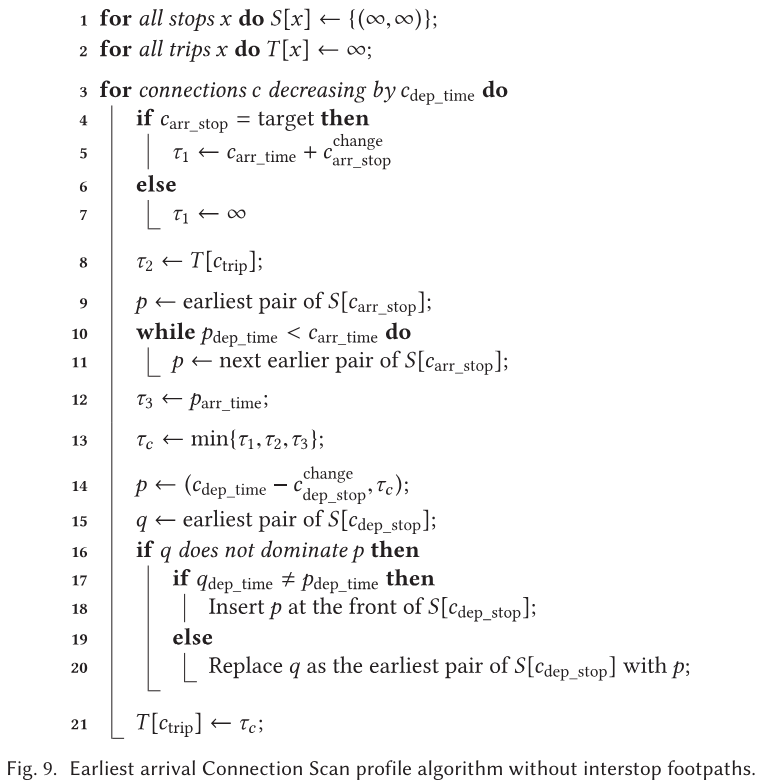

In [6]:
from IPython.display import display, Image
display(Image(filename='profile_connection_scan_algo.png'))

# Journey Extraction

### Non-Journey-Pointer version - need two auxiliary data structures

In [7]:
stops = set(list(timetable['dep_stop']) + list(timetable['arr_stop']))

# adjacency array that maps stop s to departure time and connection ID of all connections departing at s, sorted by departure time
outgoing_connections_support = {}
for stop in stops:
    outgoing_connections_support[stop] = timetable[timetable['dep_stop'] == stop][['dep_time', 'connection_id']]

# adjacency array that maps trip t onto the IDs of the connections c in the trip, ordered by position in trip
trip_connections_support = {}
timetable.sort_values(by=['trip_id', 'dep_time'])
for trip in set(timetable['trip_id']):
    trip_connections_support[trip] = timetable[timetable['trip_id'] == trip][['connection_id']]

KeyboardInterrupt: 

### Time to extract

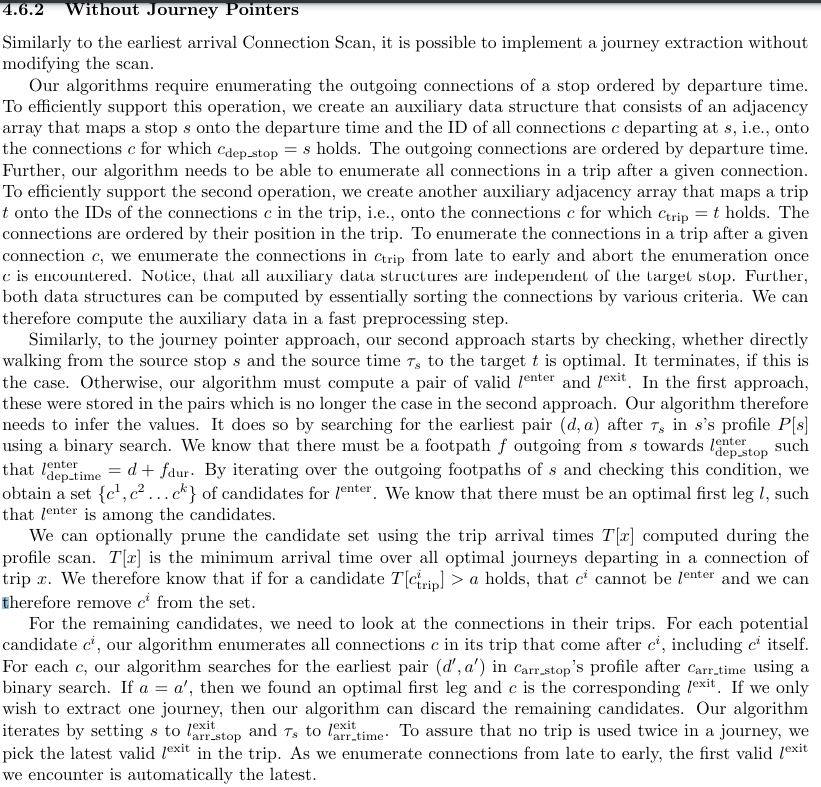

In [105]:
from IPython.display import display, Image
display(Image(filename='profile_journey_extraction.png'))

In [9]:
if S[source_stop_id][0]!=None:
    path = []
    mof = None
    step = S[source_stop_id]
    print(step)
    while step[0]!=None:
        if step[0]!=mof:
            if step[2]!=source_stop_id:
                path[-1][3] = old[3]
                path[-1][4] = old[4]
            path.append(step)
            mof = step[0]
            old = step
        else:
            old = step
        step = S[step[4]]
    if step[0]!=mof:
        path[-1][3] = old[3]
        path[-1][4] = old[4]
    path.append(step)
    print(path)

[(17400.0, 20340.0), (18300.0, 18300.0), (18360.0, 18780.0), (18660.0, 20340.0), (18780.0, 18780.0), (19140.0, 20340.0), (19200.0, 19200.0), (19260.0, 19680.0), (19320.0, 19680.0), (19380.0, 20340.0), (19680.0, 19680.0), (19740.0, 19740.0), (20040.0, 21240.0), (20100.0, 21360.0), (20160.0, 20700.0), (20220.0, 21240.0), (20340.0, 20340.0), (20460.0, 20460.0), (20580.0, 20700.0), (20700.0, 20700.0), (20820.0, 22080.0), (21000.0, 22080.0), (21060.0, 22080.0), (21120.0, 22080.0), (21240.0, 21240.0), (21360.0, 21360.0), (21480.0, 22080.0), (21600.0, 21600.0), (21660.0, 22500.0), (21900.0, 23460.0), (21960.0, 22500.0), (22020.0, 22140.0), (22080.0, 22080.0), (22140.0, 22140.0), (22260.0, 22260.0), (22380.0, 22800.0), (22500.0, 22500.0), (22560.0, 23220.0), (22680.0, 23280.0), (22800.0, 22800.0), (22920.0, 23880.0), (23160.0, 24120.0), (23220.0, 23220.0), (23280.0, 23280.0), (23460.0, 23460.0), (23520.0, 23520.0), (23580.0, 24300.0), (23760.0, 24300.0), (23820.0, 24120.0), (23880.0, 23880.0),

NameError: name 'old' is not defined